In [31]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [32]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from gammapy.modeling.models.cube import IRFModel
from Dataset_Creation import sys_dataset

## Read dataset (different coordinates for G09)

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : eQT2WNUQ 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 540263.80
  Predicted background counts     : 533641.14
  Predicted excess counts         : 6622.66

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 100300 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2462806.98

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

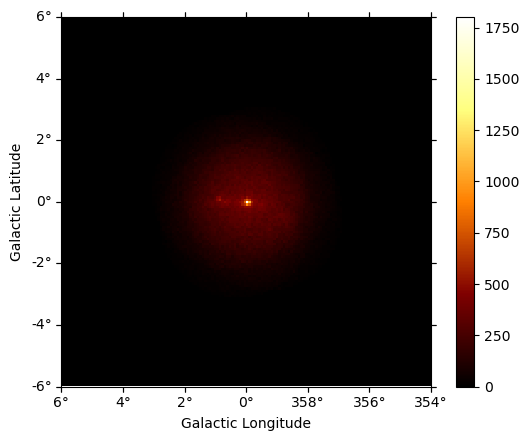

In [33]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/test2/GC_model.yml")#different coordinates for g09
models.remove('1745')
models.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].frozen = True
dataset_standard.models[0].parameters['lat_0'].frozen = True
dataset_standard.models[1].parameters['lon_0'].frozen = True
dataset_standard.models[1].parameters['lat_0'].frozen = True


dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


dataset_standard_N = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
models_N = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/test2/GC_model.yml")
models_N.remove('1745')
models_N.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_N.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard_N.name)
bkg_model.parameters['tilt'].frozen  = False
models_N.append(bkg_model)
#irf model
IRFmodel = IRFModel(dataset_name = dataset_standard_N.name)
IRFmodel.parameters['bias'].frozen  = True
IRFmodel.parameters['resolution'].frozen  = True
IRFmodel.parameters['tilt_nuisance'].frozen  = False
models_N.append(IRFmodel)
dataset_standard_N.models = models_N
#dataset_standard_N.models.parameters['norm_nuisance'].value  = 0.0
#dataset_standard_N.models.parameters['tilt_nuisance'].value  = 0.0
#dataset_standard_N.exposure = dataset_standard_N.npred_exposure()
zero = 1e-24
shift = 0.1
tilt = 0.015
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix

dataset_standard_N.models[0].parameters['lon_0'].frozen = True
dataset_standard_N.models[0].parameters['lat_0'].frozen = True
dataset_standard_N.models[1].parameters['lon_0'].frozen = True
dataset_standard_N.models[1].parameters['lat_0'].frozen = True

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
print(dataset_standard_N)
#print(dataset_asimov)

In [34]:
estimator = TSMapEstimator(
    dataset_standard.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#dataset_standard.counts.geom.axes['energy'].edges[7:17]#energy_edges=[10, 500] * u.GeV#
)
maps = estimator.run(dataset_standard)

Text(0.5, 1.0, 'Iteration map')

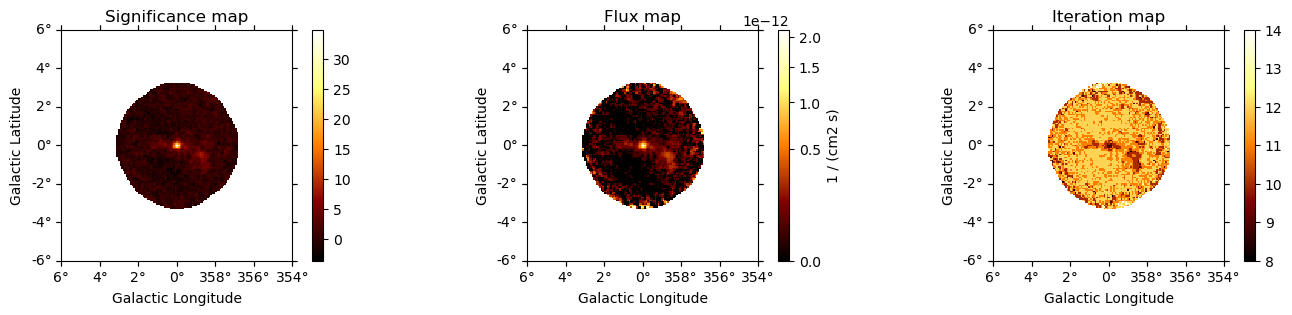

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax = ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
34.852,75,74,266.42019,-28.99116
8.8147,90,68,266.17092,-30.26529
6.7948,68,74,266.75217,-28.51273


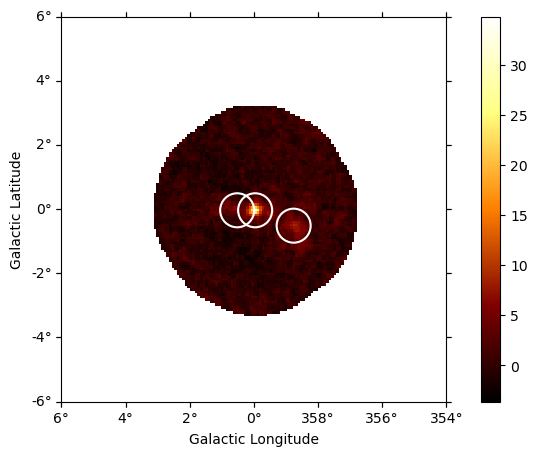

In [36]:
from gammapy.estimators.utils import find_peaks
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.25 deg")#threshold=5
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


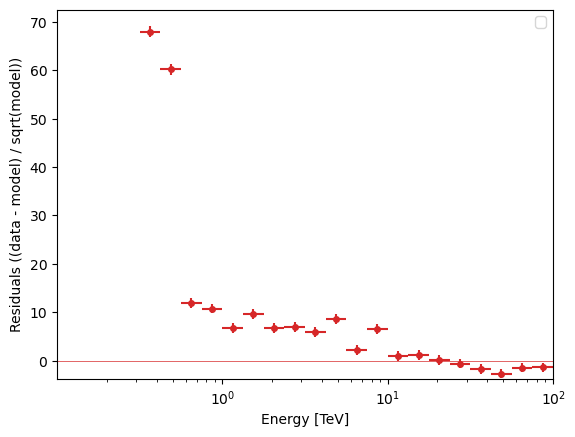

In [37]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

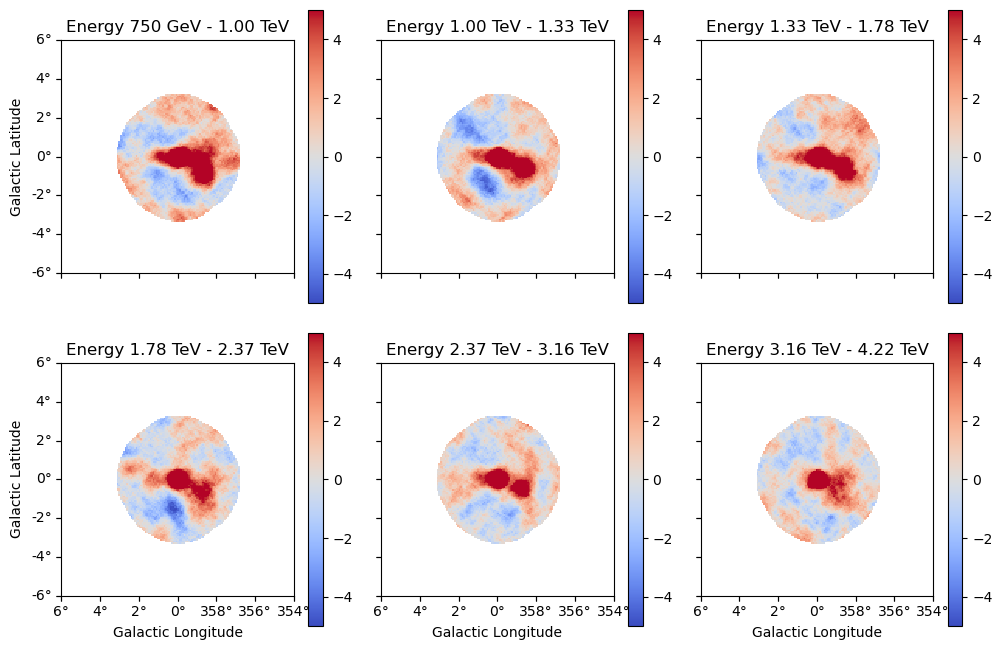

In [38]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[7:14])
result = estimator.run(dataset_standard)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

#### Setting up mask & fitting

In [39]:
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_standard_N.mask_fit = mask_space
#dataset_standard.mask_fit.plot_grid(vmin=0, vmax=1, add_cbar=True)

In [40]:
%%time
fit_standard = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_standard.backend = "minuit"
fit_standard.optimize_opts = minuit_opts
result_standard = fit_standard.run([dataset_standard])

CPU times: total: 28.2 s
Wall time: 28.3 s


In [41]:
%%time
fit_standard_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_standard_N.backend = "minuit"
fit_standard_N.optimize_opts = minuit_opts
result_standard_N = fit_standard_N.run([dataset_standard_N])

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-

CPU times: total: 2h 14min 33s
Wall time: 43min 27s


In [42]:
print(dataset_standard)

MapDataset
----------

  Name                            : eQT2WNUQ 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591517.18
  Predicted background counts     : 574774.65
  Predicted excess counts         : 16742.53

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303801.25

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramet

In [43]:
print(dataset_standard_N)

MapDataset
----------

  Name                            : HUfaPbVp 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591518.79
  Predicted background counts     : 574698.84
  Predicted excess counts         : 16819.95

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303803.62

  Number of models                : 5 
  Number of parameters            : 23
  Number of free parameters       : 10

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


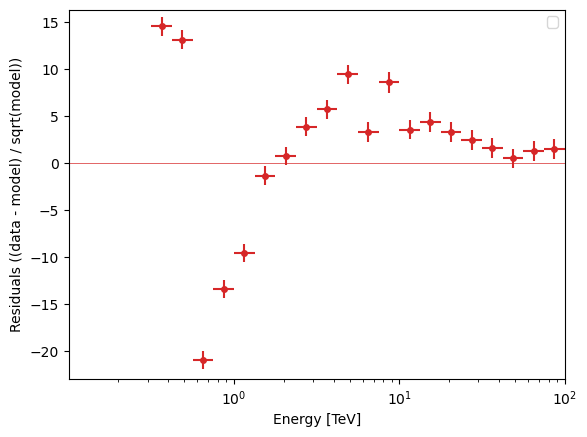

In [44]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

C:\Users\yt02izug\AppData\Local\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


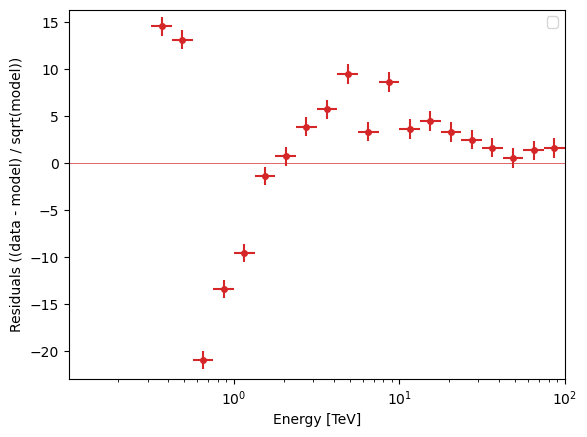

In [45]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard_N.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

In [46]:
print(dataset_standard.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.051   +/-    0.04             
    amplitude                     :   2.78e-12   +/- 8.2e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    359.940       deg         
    lat_0                 (frozen):     -0.050       deg         




In [47]:
print(dataset_standard_N.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.027   +/-    0.04             
    amplitude                     :   2.77e-12   +/- 5.2e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    359.940       deg         
    lat_0                 (frozen):     -0.050       deg         




In [48]:
for v in ['amplitude', 'index', 'lambda_']:
    for d in [dataset_standard, dataset_standard_N]:
        value = d.models['Source'].parameters[v].value
        error = d.models['Source'].parameters[v].error
        print(v,':', value, 'pm', error)

print('bkg norm: ', dataset_standard.background_model.parameters['norm'].value,' pm ', dataset_standard.background_model.parameters['norm'].error)
print('bkg norm: ', dataset_standard_N.background_model.parameters['norm'].value,' pm ', dataset_standard_N.background_model.parameters['norm'].error)

amplitude : 2.776059741310487e-12 pm 8.233558104206194e-14
amplitude : 2.773251666721655e-12 pm 5.23744870303366e-13
index : 2.0512681205770997 pm 0.03871038525668728
index : 2.027462669381383 pm 0.04080051437896278
lambda_ : 0.08861408330944395 pm 0.013507000182518715
lambda_ : 0.08874963042802124 pm 0.013198200559686837
bkg norm:  1.0573407130369386  pm  0.0016230912652478
bkg norm:  1.0572885773820189  pm  0.0016163415428389373


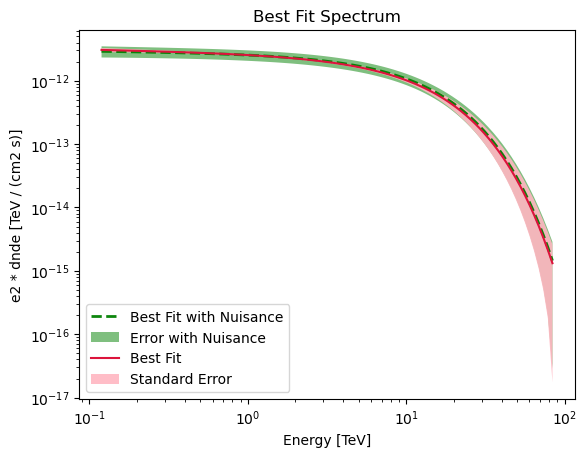

In [49]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/1b_spectra.pdf")

In [50]:
estimator = TSMapEstimator(
    dataset_standard.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#energy_edges=dataset_standard.counts.geom.axes['energy'].edges[10:14]
)
maps = estimator.run(dataset_standard)

Text(0.5, 1.0, 'Iteration map')

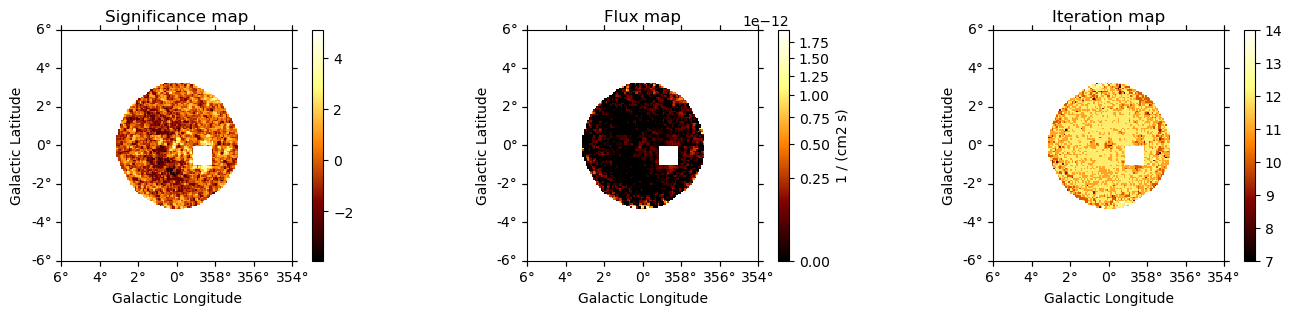

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
5.0946,73,73,266.59339,-28.89615


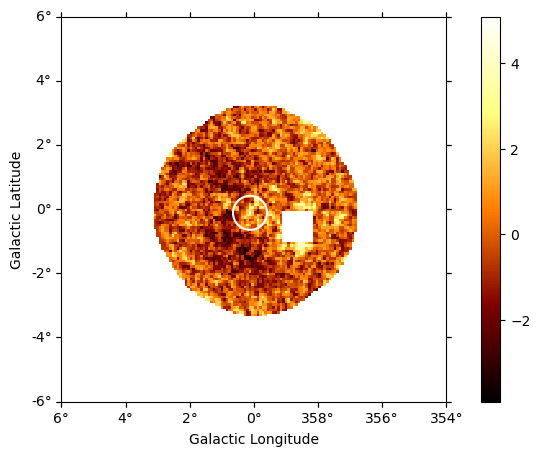

In [52]:
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.25 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

In [53]:
estimator_N = TSMapEstimator(
    dataset_standard_N.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#energy_edges=dataset_standard.counts.geom.axes['energy'].edges[10:14]
)
maps_N = estimator_N.run(dataset_standard_N)

Text(0.5, 1.0, 'Iteration map')

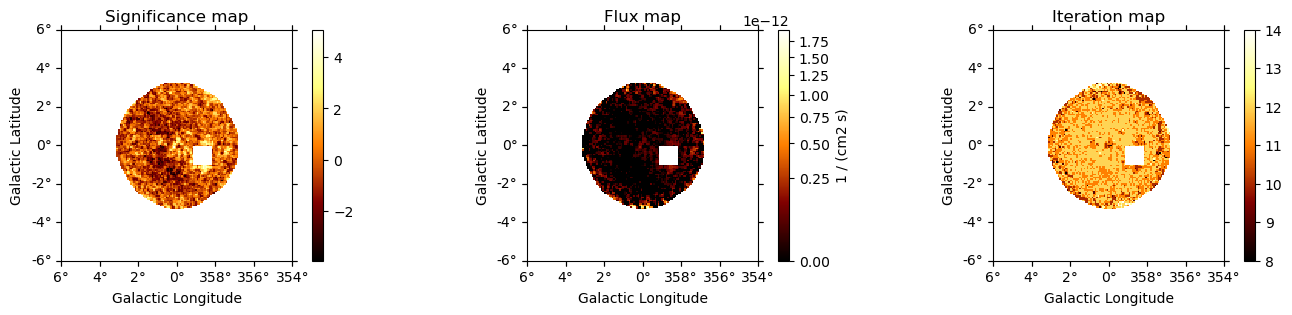

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard_N.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps_N["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps_N["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps_N["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

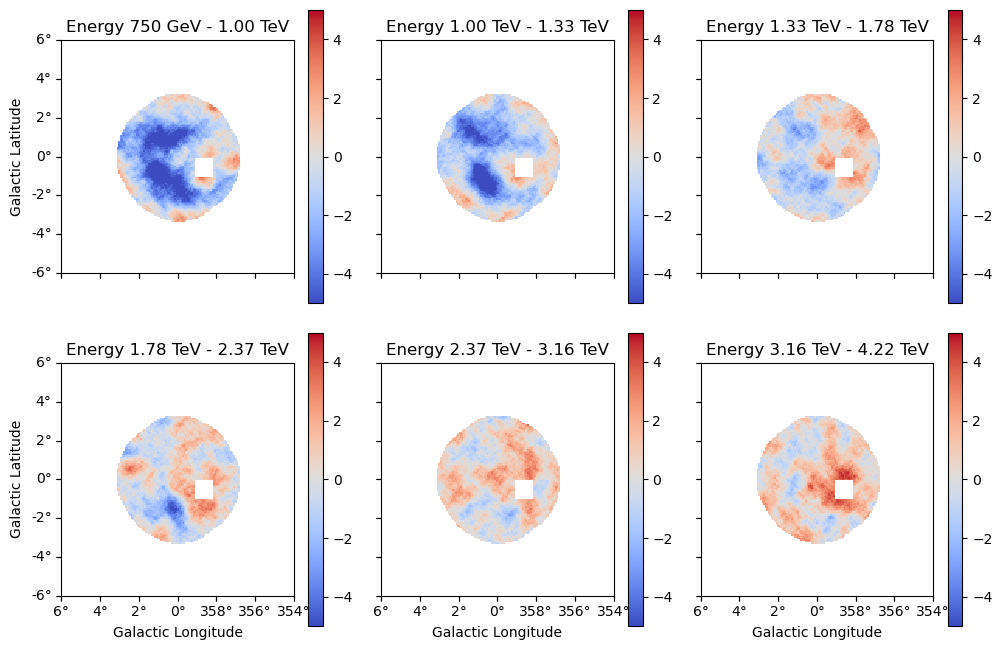

In [55]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[7:14])
result = estimator.run(dataset_standard)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

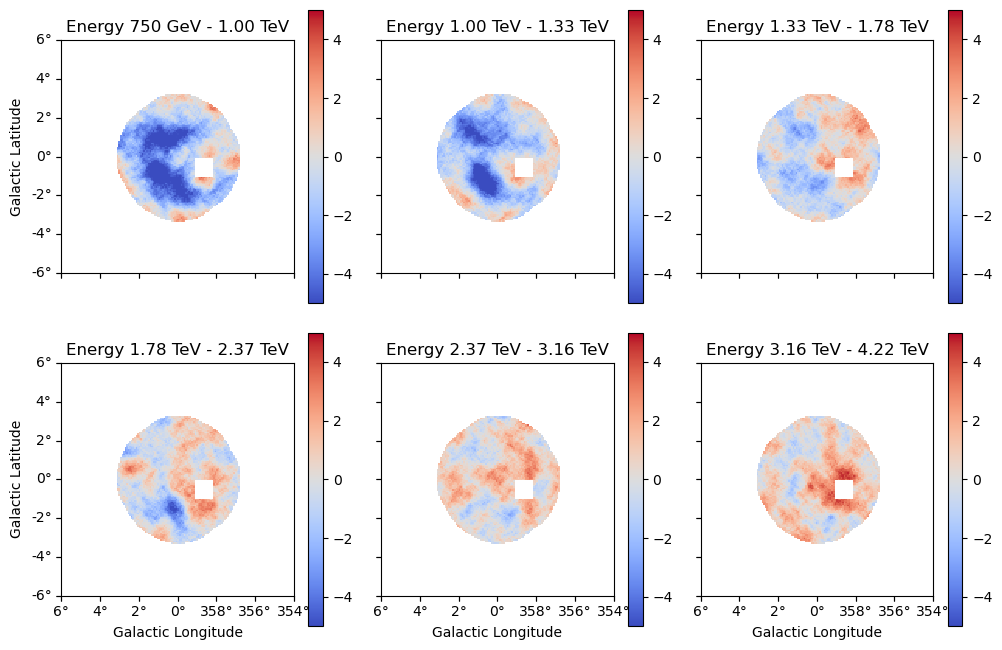

In [56]:
estimator_N = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_standard_N.counts.geom.axes['energy'].edges[7:14])
result_N = estimator_N.run(dataset_standard_N)
result_N["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [61]:
model2 = Models(dataset_standard.models).copy()
model2.remove('diff')

model2_N = Models(dataset_standard_N.models).copy()
model2_N.remove('diff')
model2_N.remove('HUfaPbVp-irf')

In [62]:
print(model2)
print(model2_N)

Models

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.051   +/-    0.04             
    amplitude                     :   2.78e-12   +/- 8.2e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    359.940       deg         
    lat_0                 (frozen):     -0.050       deg         

Component 1: SkyModel

  Name                      : g09
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index       

In [63]:
model2.write("data/1_model_standard_best_fit_mask.yml", overwrite= True)

In [64]:
model2_N.write("data/1_model_standard_nuisance_fit_mask.yml", overwrite= True)